In [1]:

from pathlib import Path
from typing import List, Dict, Any, Union
import json

# Option A: Point to a directory — we'll read all *.json files in it (non-recursive).
DATA_DIR = Path('../artifacts/BPI_2017_W_sample')  # change this if needed

# Option B: Or list explicit paths (these will be used in addition to any files in DATA_DIR).
DATA_PATHS: List[Union[str, Path]] = [
    #'../artifacts/experiments_BPI_2012_W_sample.json'
]

# If DATA_DIR doesn't exist, we'll ignore it and fall back to DATA_PATHS.
print('DATA_DIR:', DATA_DIR)
print('Additional DATA_PATHS:', DATA_PATHS)


DATA_DIR: ..\artifacts\BPI_2017_W_sample
Additional DATA_PATHS: []


In [2]:
import glob

def _read_json_file(path: Union[str, Path]) -> list:
    """
    Reads a JSON file that contains either:
      - a list of experiments, or
      - a single experiment dict
    Returns a list of experiment dicts.
    """
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    if isinstance(data, list):
        return data
    elif isinstance(data, dict):
        return [data]
    else:
        raise ValueError(f'Unsupported JSON root type in {path}: {type(data)}')

def discover_experiment_files(dir_path: Path, extra_paths: List[Union[str, Path]]) -> list:
    files = []
    if dir_path and dir_path.exists() and dir_path.is_dir():
        files.extend(sorted(Path(p) for p in glob.glob(str(dir_path / '*.json'))))
    for p in extra_paths:
        p = Path(p)
        if p.exists() and p.is_file():
            files.append(p)
    # de-duplicate while preserving order
    seen = set()
    unique_files = []
    for p in files:
        if p.resolve() not in seen:
            unique_files.append(p)
            seen.add(p.resolve())
    return unique_files

files = discover_experiment_files(DATA_DIR, DATA_PATHS)
if not files:
    print('No JSON files found. Add files to /mnt/data/experiments or list them in DATA_PATHS.')
else:
    print('Found files:')
    for f in files:
        print(' -', f)


Found files:
 - ..\artifacts\BPI_2017_W_sample\experiment_20250818T210232Z.json
 - ..\artifacts\BPI_2017_W_sample\experiment_20250818T210649Z.json
 - ..\artifacts\BPI_2017_W_sample\experiment_20250818T211105Z.json
 - ..\artifacts\BPI_2017_W_sample\experiment_20250818T211547Z.json
 - ..\artifacts\BPI_2017_W_sample\experiment_20250818T212106Z.json
 - ..\artifacts\BPI_2017_W_sample\experiment_20250818T212606Z.json
 - ..\artifacts\BPI_2017_W_sample\experiment_20250818T213149Z.json
 - ..\artifacts\BPI_2017_W_sample\experiment_20250818T214113Z.json
 - ..\artifacts\BPI_2017_W_sample\experiment_20250818T214700Z.json
 - ..\artifacts\BPI_2017_W_sample\experiment_20250818T215244Z.json
 - ..\artifacts\BPI_2017_W_sample\experiment_20250818T215848Z.json
 - ..\artifacts\BPI_2017_W_sample\experiment_20250818T220516Z.json
 - ..\artifacts\BPI_2017_W_sample\experiment_20250818T220942Z.json
 - ..\artifacts\BPI_2017_W_sample\experiment_20250818T221709Z.json
 - ..\artifacts\BPI_2017_W_sample\experiment_2025

In [3]:

import pandas as pd

def _safe_get(d: Dict, path: List[str], default=None):
    cur = d
    for k in path:
        if isinstance(cur, dict) and k in cur:
            cur = cur[k]
        else:
            return default
    return cur

def _model_label(cfg: Dict[str, Any]) -> str:
    # Build something concise like: LSTM(64x1, drop=0.0, lr=0.001)
    mtype = _safe_get(cfg, ['model', 'type'], 'model')
    mparams = _safe_get(cfg, ['model', 'params'], {}) or {}
    task = mparams.get('task')
    hidden = mparams.get('hidden_size')
    layers = mparams.get('num_layers')
    dropout = mparams.get('dropout')
    lr = mparams.get('lr')
    
    # Short primary
    short = f"{mtype.upper()}"
    if hidden and layers:
        short += f" ({hidden}x{layers})"
    
    '''
    # Terse extras
    extras = []
    if dropout is not None: extras.append(f"drop={dropout}")
    if lr is not None: extras.append(f"lr={lr}")
    if task: extras.append(task)
    if extras:
        short += ' [' + ', '.join(map(str, extras)) + ']'
    # Include transformer if present
    tkey = _safe_get(cfg, ['transformer', 'key'])
    if tkey:
        short = f"{short} ⇥ {tkey}"
    '''
    return short

def _features_label(cfg: Dict[str, Any]) -> str:
    feats = _safe_get(cfg, ['features'], []) or []
    labels = [_feature_label(f) for f in feats]
    return ' + '.join(labels) if labels else '—'

def _feature_label(feat: Dict[str, Any]) -> str:
    # Example:
    # { "feature_key": "time_in_day", "source_col_name": "time:timestamp",
    #   "encoding_key": "numeric", "granularity_key": "hour" }
    parts = []
    fk = feat.get('feature_key')
    sc = feat.get('source_col_name')
    enc = feat.get('encoding_key')
    gran = feat.get('granularity_key')
    base = fk or sc or 'feature'
    if gran:
        base = f"{base}:{gran}"
    if enc:
        base = f"{base}:{enc}"
    return base

def _build_label(cfg: Dict[str, Any]) -> str:
    # Full label combining model and features in a compact way
    model = _model_label(cfg)
    feats = _features_label(cfg)
    target = _safe_get(cfg, ['target']) or _safe_get(cfg, ['config', 'target'])
    if target:
        return f"model: {model}\nfeatures: {feats}\n target: {target}"
    return f"model: {model}\nfeatures: {feats}"
    return f"features: {feats}"

records = []
for f in files:
    try:
        runs = _read_json_file(f)
        for r in runs:
            cfg = r.get('config', {})
            metrics = r.get('metrics', {})
            rec = {
                'file': str(f),
                'artifact_path': r.get('artifact_path'),
                'seed': _safe_get(cfg, ['seed']),
                'dataset_path': _safe_get(cfg, ['dataset', 'path']),
                'case_id_col': _safe_get(cfg, ['dataset', 'case_id_col']),
                'activity_col': _safe_get(cfg, ['dataset', 'activity_col']),
                'timestamp_col': _safe_get(cfg, ['dataset', 'timestamp_col']),
                'split_type': _safe_get(cfg, ['split', 'type']),
                'test_ratio': _safe_get(cfg, ['split', 'params', 'test_ratio']),
                'val_ratio': _safe_get(cfg, ['split', 'params', 'val_ratio']),
                'model_type': _safe_get(cfg, ['model', 'type']),
                'model_params': _safe_get(cfg, ['model', 'params'], {}),
                'transformer_key': _safe_get(cfg, ['transformer', 'key']),
                'target': _safe_get(cfg, ['target']),
                'features_summary': _features_label(cfg),
                'labels': _build_label(cfg),
                # Metrics
                'mae': metrics.get('mae'),
                'mse': metrics.get('mse'),
                'rmse': metrics.get('rmse'),
                'mape': metrics.get('mape'),
            }
            records.append(rec)
    except Exception as e:
        print(f'Error reading {f}:', e)

df = pd.DataFrame.from_records(records)
print('Loaded runs:', len(df))
df.head(3)


Loaded runs: 61


,file,artifact_path,seed,dataset_path,case_id_col,activity_col,timestamp_col,split_type,test_ratio,val_ratio,model_type,model_params,transformer_key,target,features_summary,labels,mae,mse,rmse,mape
0,..\artifacts\BPI_2017_W_sample\experiment_2025...,None,42,data/raw/BPI_2017_W_sample.xes,case:concept:name,concept:name,time:timestamp,temporal,0.15,0.15,lstm,"{'task': 'regression', 'hidden_size': 64, 'num...",lstm,remaining_time,feature:onehot + utc:second:numeric,model: LSTM (64x1)\nfeatures: feature:onehot +...,743372.053789,1.166038e+12,1.079832e+06,2704.306312
1,..\artifacts\BPI_2017_W_sample\experiment_2025...,None,42,data/raw/BPI_2017_W_sample.xes,case:concept:name,concept:name,time:timestamp,temporal,0.15,0.15,lstm,"{'task': 'regression', 'hidden_size': 64, 'num...",lstm,remaining_time,feature:onehot + utc:minute:numeric,model: LSTM (64x1)\nfeatures: feature:onehot +...,743371.510428,1.166035e+12,1.079831e+06,2704.328901
2,..\artifacts\BPI_2017_W_sample\experiment_2025...,None,42,data/raw/BPI_2017_W_sample.xes,case:concept:name,concept:name,time:timestamp,temporal,0.15,0.15,lstm,"{'task': 'regression', 'hidden_size': 64, 'num...",lstm,remaining_time,feature:onehot + utc:hour:numeric,model: LSTM (64x1)\nfeatures: feature:onehot +...,741602.657130,1.157513e+12,1.075878e+06,2851.937094


In [4]:
df["time_feature_summary"] = df["features_summary"].str.replace(r".*\+ ", "", regex=True)
split_cols = df["time_feature_summary"].str.split(":", expand=True)
df[["time_feature", "granularity", "encoding"]] = split_cols
df.head(3)

,file,artifact_path,seed,dataset_path,case_id_col,activity_col,timestamp_col,split_type,test_ratio,val_ratio,...,features_summary,labels,mae,mse,rmse,mape,time_feature_summary,time_feature,granularity,encoding
0,..\artifacts\BPI_2017_W_sample\experiment_2025...,None,42,data/raw/BPI_2017_W_sample.xes,case:concept:name,concept:name,time:timestamp,temporal,0.15,0.15,...,feature:onehot + utc:second:numeric,model: LSTM (64x1)\nfeatures: feature:onehot +...,743372.053789,1.166038e+12,1.079832e+06,2704.306312,utc:second:numeric,utc,second,numeric
1,..\artifacts\BPI_2017_W_sample\experiment_2025...,None,42,data/raw/BPI_2017_W_sample.xes,case:concept:name,concept:name,time:timestamp,temporal,0.15,0.15,...,feature:onehot + utc:minute:numeric,model: LSTM (64x1)\nfeatures: feature:onehot +...,743371.510428,1.166035e+12,1.079831e+06,2704.328901,utc:minute:numeric,utc,minute,numeric
2,..\artifacts\BPI_2017_W_sample\experiment_2025...,None,42,data/raw/BPI_2017_W_sample.xes,case:concept:name,concept:name,time:timestamp,temporal,0.15,0.15,...,feature:onehot + utc:hour:numeric,model: LSTM (64x1)\nfeatures: feature:onehot +...,741602.657130,1.157513e+12,1.075878e+06,2851.937094,utc:hour:numeric,utc,hour,numeric


In [5]:

import pandas as pd

if df.empty:
    print('No runs loaded. Please check DATA_DIR / DATA_PATHS.')
else:
    # Keep only rows with MAE
    df_error = df.dropna(subset=['mae']).copy()
    print(f'Runs with MAE: {len(df_error)}')
    display_cols = [
        'labels', "time_feature", "granularity", "encoding", 'mae', 'rmse', 'mape', 
    ]
    display(df_error[display_cols].sort_values('mae', ascending=True).reset_index(drop=True).head(10))

    # Quick summary stats
    print('\nMAE Summary Stats:')
    print(df_error['mae'].describe())


Runs with MAE: 61


,labels,time_feature,granularity,encoding,mae,rmse,mape
0,model: LSTM (64x1)\nfeatures: feature:onehot +...,time_since_last_event,hour,numeric,727513.935175,1.061135e+06,2138.899509
1,model: LSTM (64x1)\nfeatures: feature:onehot +...,time_since_last_event,week,numeric,728084.829457,1.061019e+06,2219.533839
2,model: LSTM (64x1)\nfeatures: feature:onehot +...,time_since_last_event,day,numeric,728186.768225,1.062137e+06,2193.766848
3,model: LSTM (64x1)\nfeatures: feature:onehot +...,time_since_last_event,minute,numeric,730433.262882,1.069026e+06,1890.845703
4,model: LSTM (64x1)\nfeatures: feature:onehot +...,time_since_last_event,second,numeric,730434.413570,1.069027e+06,1890.791141
5,model: LSTM (64x1)\nfeatures: feature:onehot +...,time_since_start,day,numeric,733407.092140,1.074527e+06,1855.918919
6,model: LSTM (64x1)\nfeatures: feature:onehot +...,time_since_start,hour,numeric,734127.782084,1.075870e+06,1812.744097
7,model: LSTM (64x1)\nfeatures: feature:onehot +...,time_since_start,second,numeric,735588.960984,1.077409e+06,1802.266904
8,model: LSTM (64x1)\nfeatures: feature:onehot +...,time_since_start,minute,numeric,735589.258560,1.077410e+06,1802.284372
9,model: LSTM (64x1)\nfeatures: feature:onehot +...,time_in_day,minute,numeric,735872.094547,1.077491e+06,2347.338727



MAE Summary Stats:
count        61.000000
mean     745285.627959
std       10121.242970
min      727513.935175
25%      739634.411428
50%      743264.976287
75%      751926.178063
max      768511.695177
Name: mae, dtype: float64


C:\Users\m711912\AppData\Local\Temp\ipykernel_15304\209874647.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


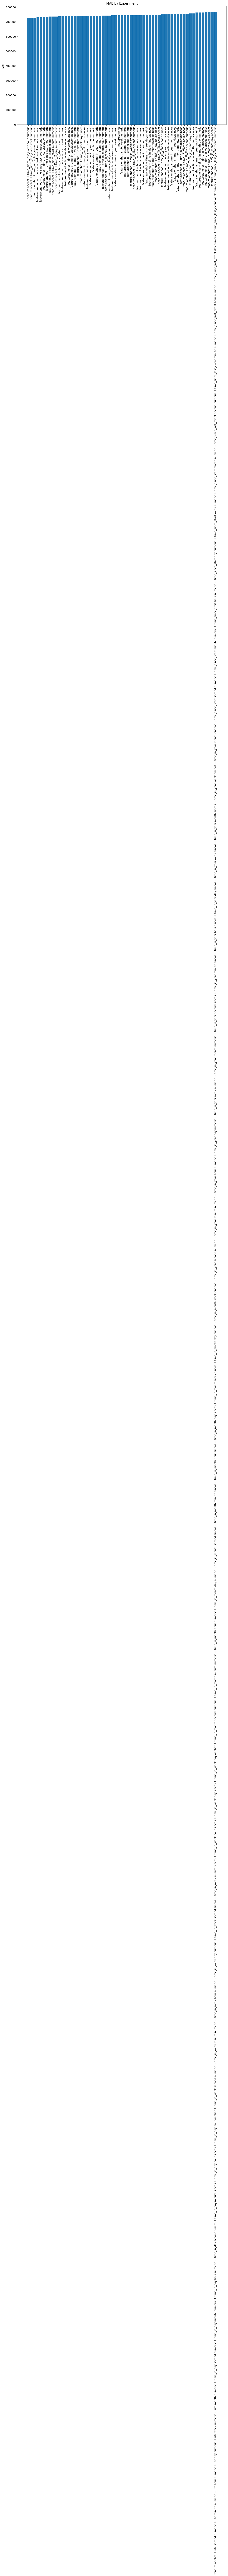

In [6]:

import matplotlib.pyplot as plt

if not df.empty and df['mae'].notna().any():
    df_plot = df.sort_values('mae', ascending=True).reset_index(drop=True)
    labels = df_plot['features_summary'].tolist()
    plt.figure(figsize=(14, 8))
    plt.bar(range(len(df_plot)), df_plot['mae'])
    plt.xticks(range(len(df_plot)), labels, rotation=90)
    plt.ylabel('MAE')
    plt.title('MAE by Experiment')
    plt.tight_layout()
    #out_path = '/mnt/data/mae_with_labels.png'
    #plt.savefig(out_path, dpi=150)
    plt.show()
else:
    print('No MAE values to plot.')


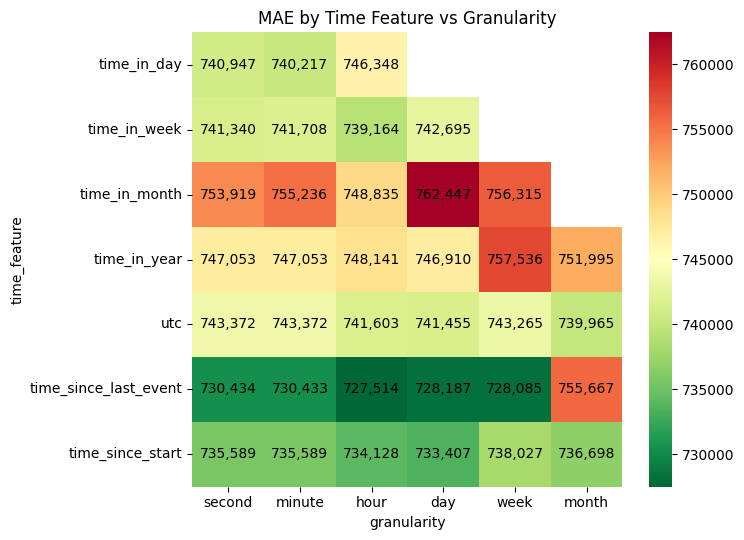

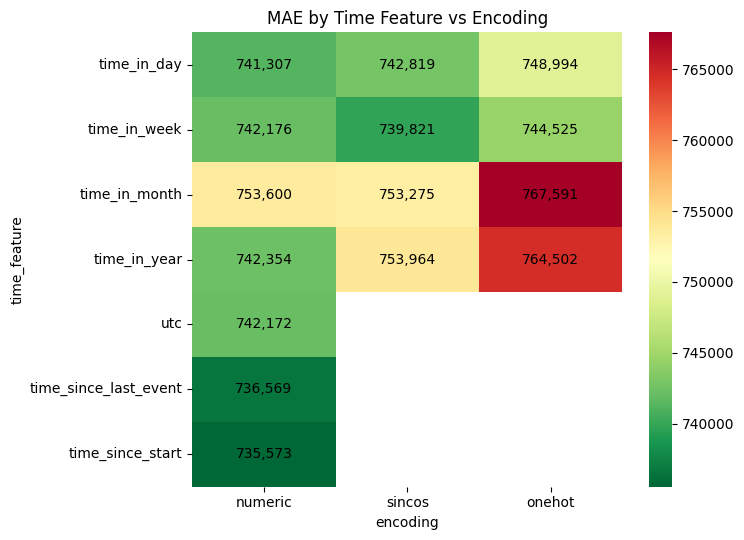

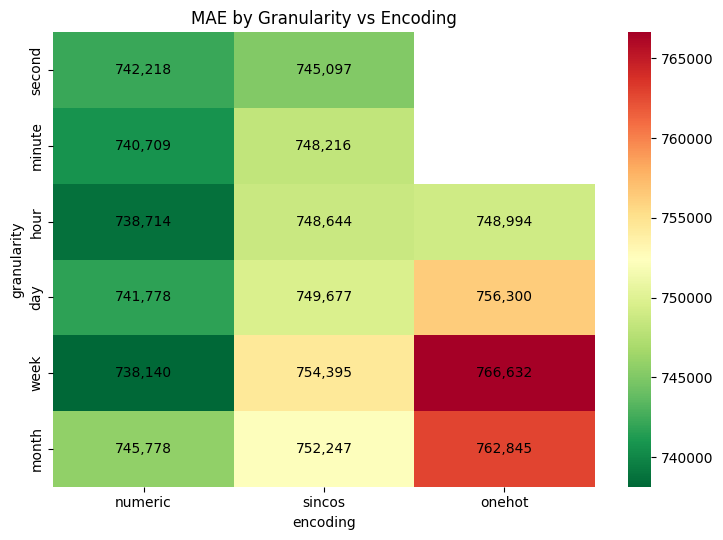

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ----- desired orders -----
time_feature_order = ["time_in_day", "time_in_week", "time_in_month", "time_in_year","utc","time_since_last_event", "time_since_start"]
granularity_order  = ["second", "minute", "hour", "day", "week", "month"]
encoding_order     = ["numeric", "sincos", "onehot"]

# (optional) trim any whitespace/artifacts like trailing " -"
df["time_feature"] = df["time_feature"].astype(str).str.strip().str.replace(r"\s*-\s*$", "", regex=True)
df["granularity"]  = df["granularity"].astype(str).str.strip()
df["encoding"]     = df["encoding"].astype(str).str.strip()

# set categorical dtype with your order
df["time_feature"] = pd.Categorical(df["time_feature"], categories=time_feature_order, ordered=True)
df["granularity"]  = pd.Categorical(df["granularity"],  categories=granularity_order,  ordered=True)
df["encoding"]     = pd.Categorical(df["encoding"],     categories=encoding_order,     ordered=True)

def heatmap_with_commas(pivot, title, xlabel, ylabel):
    plt.figure(figsize=(7.5, 5.5))
    # numeric data for colors
    ax = sns.heatmap(pivot, annot=False, cmap="RdYlGn_r")
    # formatted text overlays with thousands separators and 1 decimal
    labels = pivot.copy()
    labels = labels.map(lambda v: f"{v:,.0f}" if pd.notnull(v) else "")
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            ax.text(j + 0.5, i + 0.5, labels.iat[i, j],
                    ha='center', va='center', fontsize=10)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# 1) time_feature x granularity
p1 = df.pivot_table(values="mae", index="time_feature", columns="granularity", aggfunc="mean", observed=False)
heatmap_with_commas(p1, "MAE by Time Feature vs Granularity", "granularity", "time_feature")

# 2) time_feature x encoding
p2 = df.pivot_table(values="mae", index="time_feature", columns="encoding", aggfunc="mean", observed=False)
heatmap_with_commas(p2, "MAE by Time Feature vs Encoding", "encoding", "time_feature")

# 3) granularity x encoding
p3 = df.pivot_table(values="mae", index="granularity", columns="encoding", aggfunc="mean", observed=False)
heatmap_with_commas(p3, "MAE by Granularity vs Encoding", "encoding", "granularity")


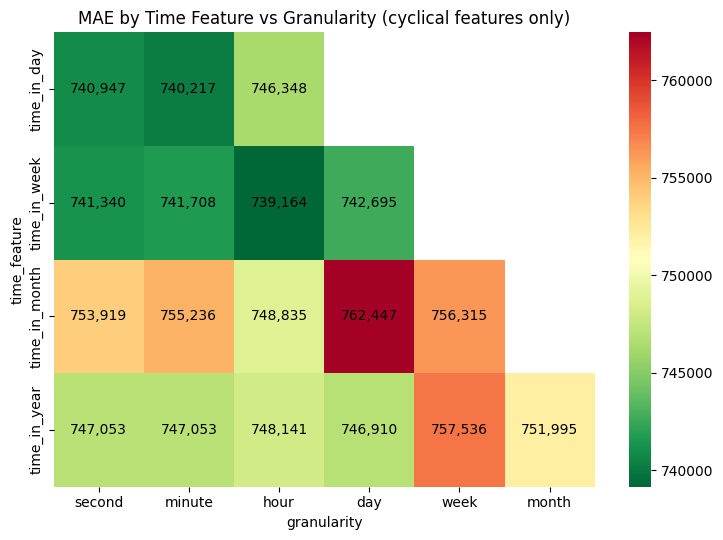

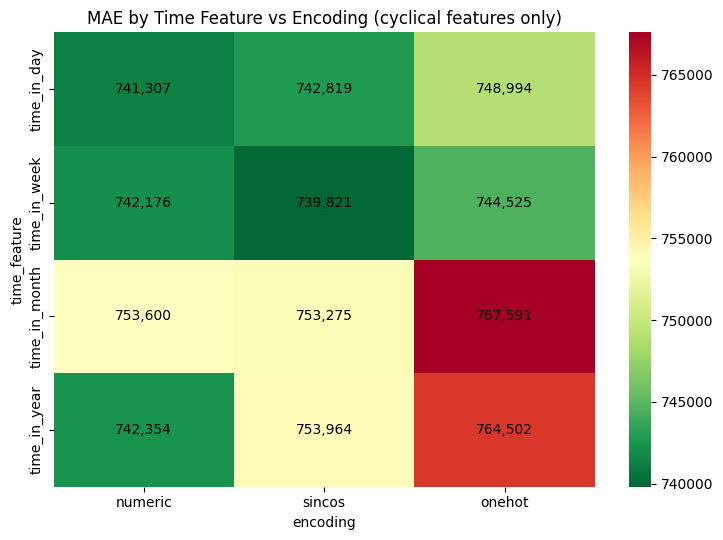

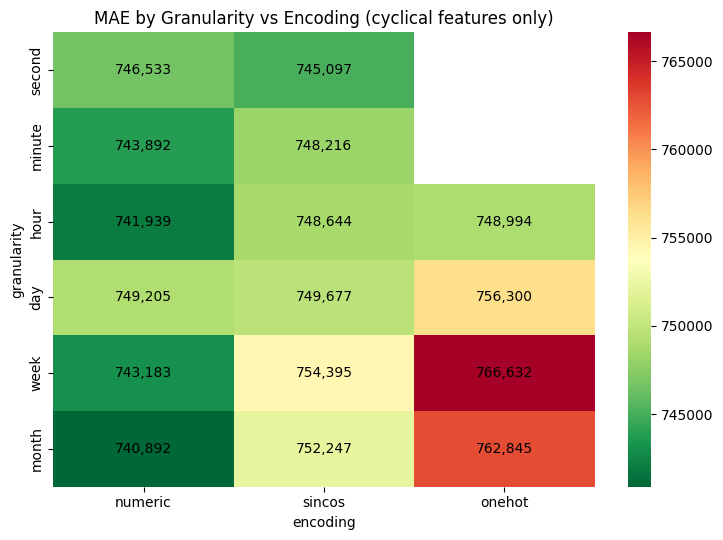

In [8]:
# set this to True if you want to skip those rows
skip_long_features = True  

# base DataFrame
df_plot = df.copy()

if skip_long_features:
    df_plot = df_plot[~df_plot["time_feature"].isin(["time_since_last_event", "time_since_start", "utc"])]

# recompute pivots using the filtered df
p1 = df_plot.pivot_table(values="mae", index="time_feature", columns="granularity", aggfunc="mean", observed=False)
heatmap_with_commas(p1, "MAE by Time Feature vs Granularity (cyclical features only)", "granularity", "time_feature")

p2 = df_plot.pivot_table(values="mae", index="time_feature", columns="encoding", aggfunc="mean", observed=False)
heatmap_with_commas(p2, "MAE by Time Feature vs Encoding (cyclical features only)", "encoding", "time_feature")

p3 = df_plot.pivot_table(values="mae", index="granularity", columns="encoding", aggfunc="mean", observed=False)
heatmap_with_commas(p3, "MAE by Granularity vs Encoding (cyclical features only)", "encoding", "granularity")


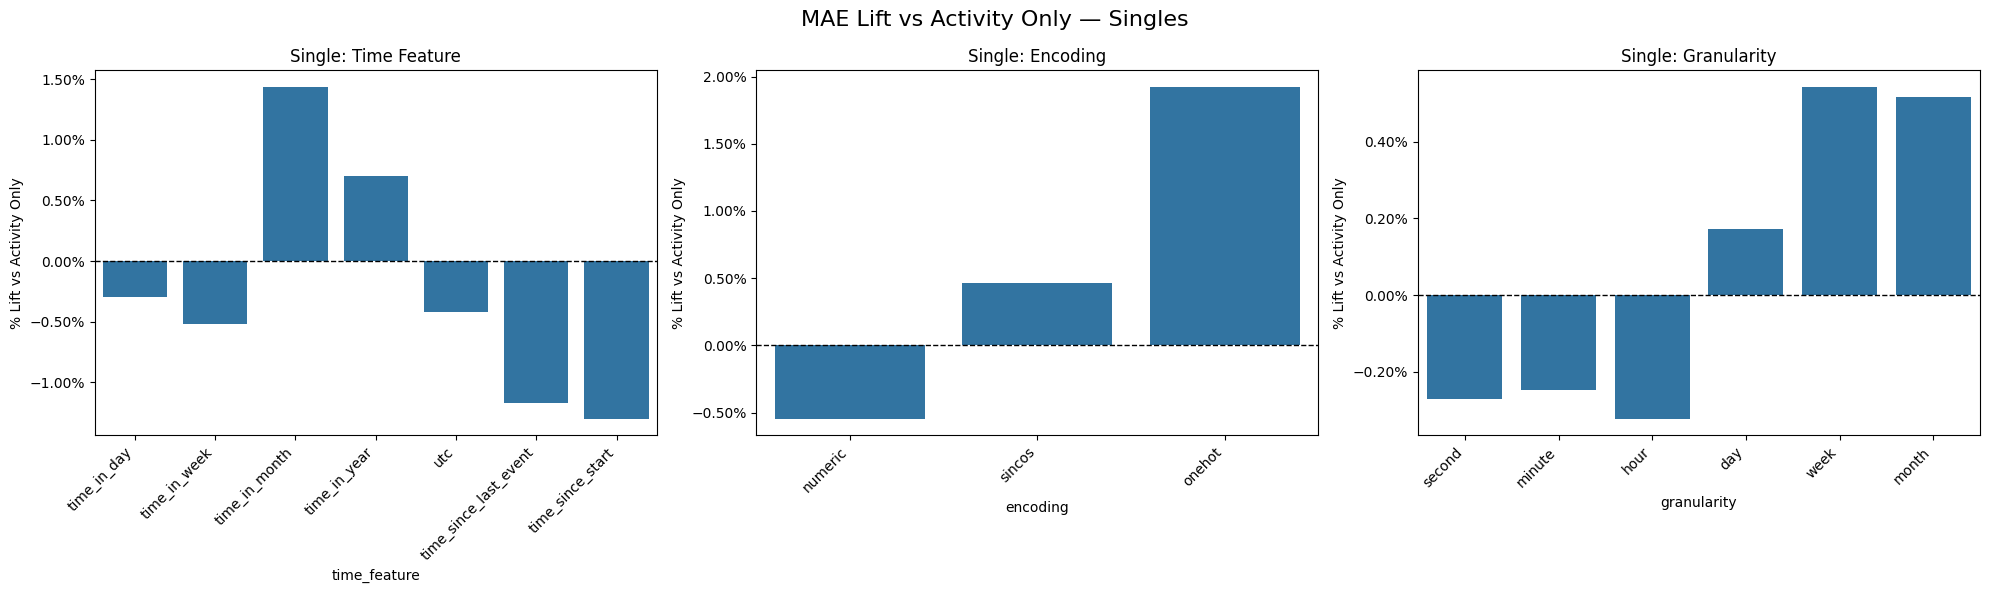

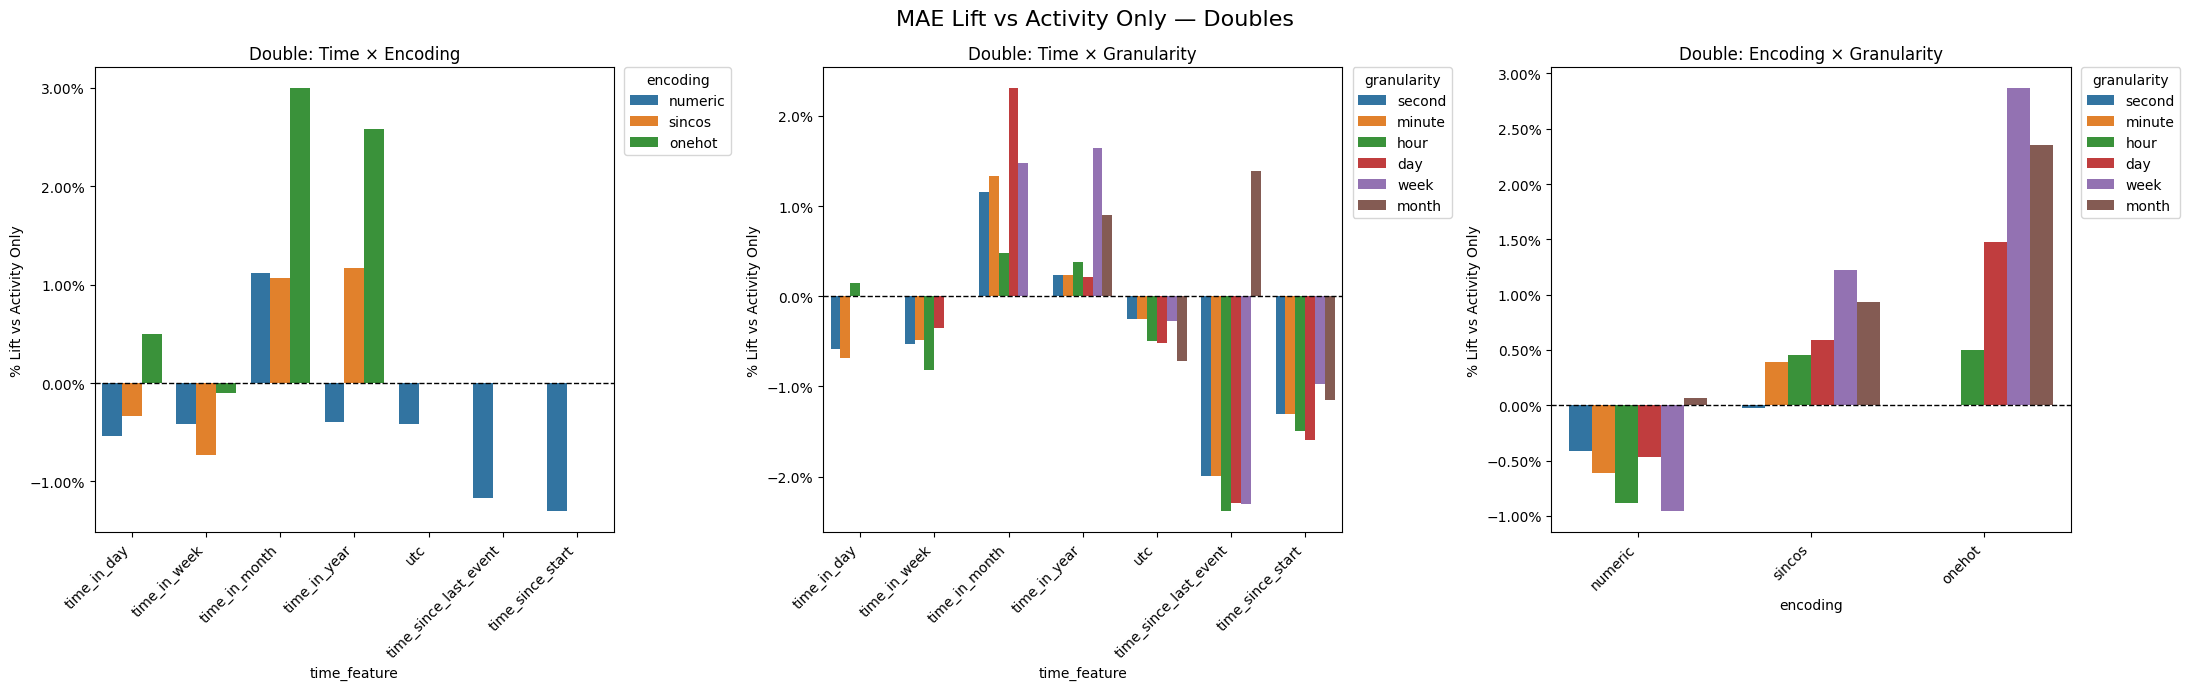

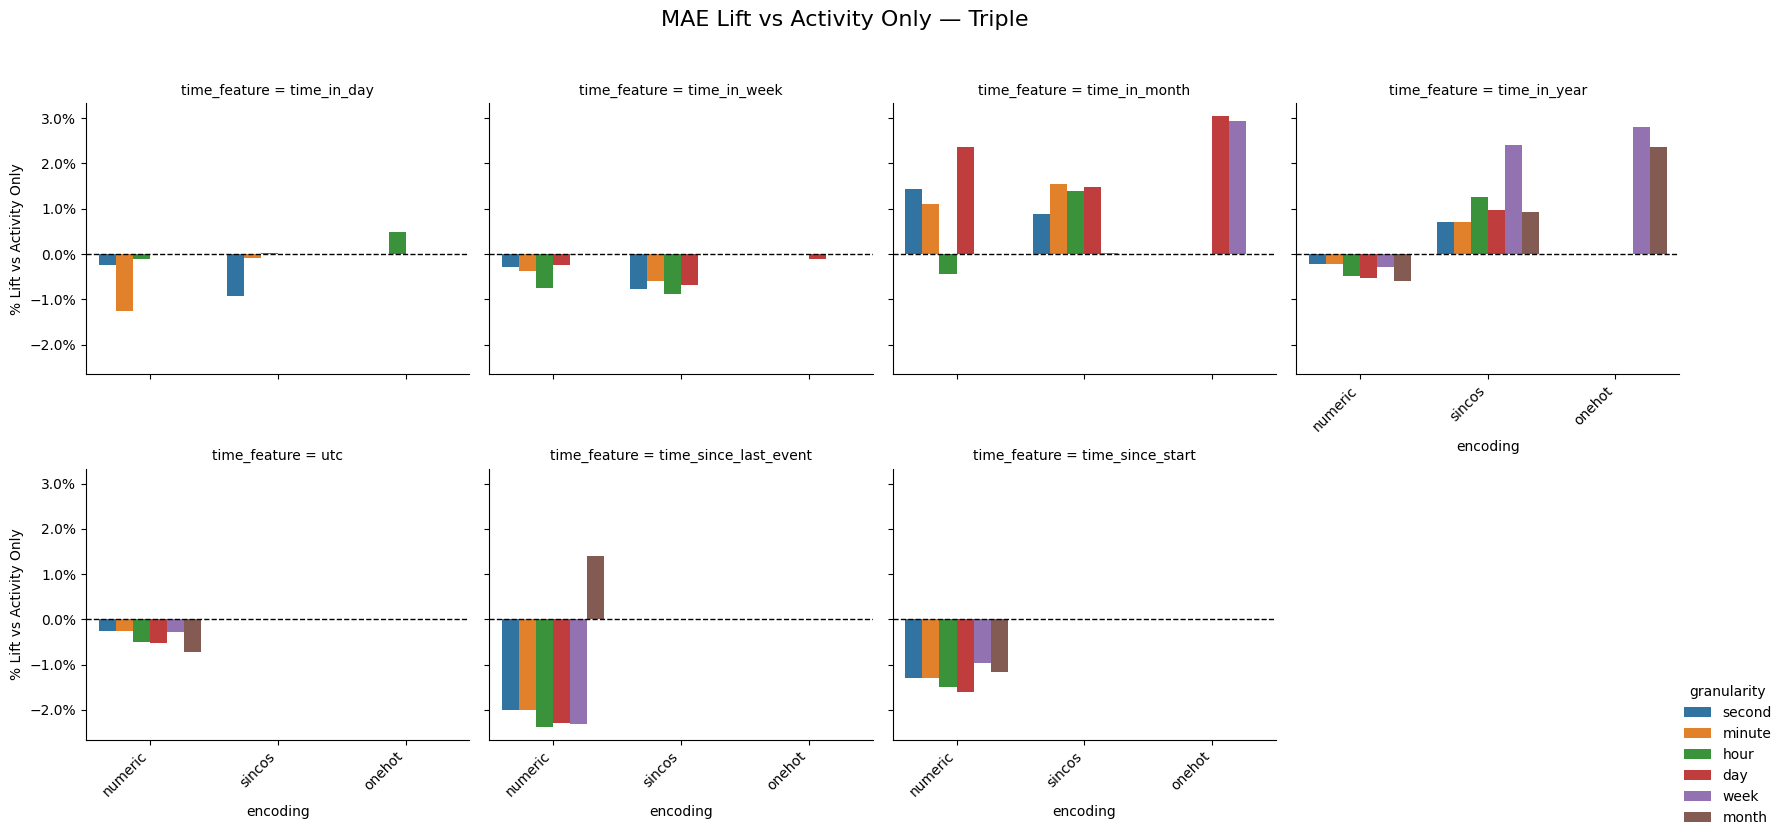

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from pandas.api.types import CategoricalDtype

# -----------------------------
# 0) Lock category orders
# -----------------------------
ORDER_GRAN = ["second", "minute", "hour", "day", "week", "month"]
ORDER_ENC  = ["numeric", "sincos", "onehot"]
ORDER_FEA = ["time_in_day", "time_in_week", "time_in_month", "time_in_year", "utc", "time_since_last_event", "time_since_start"]

df_red = df[["time_feature", "granularity", "encoding", "mae"]].copy()

df_red["granularity"] = df_red["granularity"].astype(
    CategoricalDtype(categories=ORDER_GRAN, ordered=True)
)
df_red["encoding"] = df_red["encoding"].astype(
    CategoricalDtype(categories=ORDER_ENC, ordered=True)
)
df_red["time_feature"] = df_red["time_feature"].astype(
    CategoricalDtype(categories=ORDER_FEA, ordered=True)
)

global_baseline = df_red["mae"].mean() # mean baseline across all rows
#global_baseline = df_red.loc[df[["time_feature", "granularity", "encoding"]].isna().all(axis=1), "mae"].iloc[0] # baseline is experiment with only act feature

# -----------------------------
# 1) Aggregations with lift
# -----------------------------
# triple
agg_fea_enc_gran = (
    df_red.groupby(["time_feature", "encoding", "granularity"], observed=True)["mae"]
    .mean()
    .reset_index()
)
agg_fea_enc_gran["lift_vs_global"] = (agg_fea_enc_gran["mae"] - global_baseline) / global_baseline * 100

# doubles
agg_fea_enc = df_red.groupby(["time_feature", "encoding"], observed=True)["mae"].mean().reset_index()
agg_fea_enc["lift_vs_global"] = (agg_fea_enc["mae"] - global_baseline) / global_baseline * 100

agg_fea_gran = df_red.groupby(["time_feature", "granularity"], observed=True)["mae"].mean().reset_index()
agg_fea_gran["lift_vs_global"] = (agg_fea_gran["mae"] - global_baseline) / global_baseline * 100

agg_enc_gran = df_red.groupby(["encoding", "granularity"], observed=True)["mae"].mean().reset_index()
agg_enc_gran["lift_vs_global"] = (agg_enc_gran["mae"] - global_baseline) / global_baseline * 100

# singles
agg_fea = df_red.groupby(["time_feature"], observed=True)["mae"].mean().reset_index()
agg_fea["lift_vs_global"] = (agg_fea["mae"] - global_baseline) / global_baseline * 100

agg_enc = df_red.groupby(["encoding"], observed=True)["mae"].mean().reset_index()
agg_enc["lift_vs_global"] = (agg_enc["mae"] - global_baseline) / global_baseline * 100

agg_gran = df_red.groupby(["granularity"], observed=True)["mae"].mean().reset_index()
agg_gran["lift_vs_global"] = (agg_gran["mae"] - global_baseline) / global_baseline * 100

# -----------------------------
# 2) Helpers (no sorting; respect fixed orders)
# -----------------------------
def set_percent_axis(ax, axis="y"):
    fmt = PercentFormatter(xmax=100)
    if axis == "y":
        ax.yaxis.set_major_formatter(fmt)
        ax.axhline(0, color="black", linestyle="--", linewidth=1)
        ax.set_ylabel("% Lift vs Activity Only")
    else:
        ax.xaxis.set_major_formatter(fmt)
        ax.axvline(0, color="black", linestyle="--", linewidth=1)
        ax.set_xlabel("% Lift vs Activity Only")

def bar_single(ax, data, xcol, title, order):
    sns.barplot(ax=ax, data=data, x=xcol, y="lift_vs_global", order=order)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_horizontalalignment("right")
    set_percent_axis(ax, axis="y")
    ax.set_title(title)

def bar_grouped(ax, data, xcol, huecol, title, x_order, hue_order):
    sns.barplot(
        ax=ax, data=data, x=xcol, y="lift_vs_global",
        hue=huecol, order=x_order, hue_order=hue_order
    )
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_horizontalalignment("right")
    set_percent_axis(ax, axis="y")
    ax.set_title(title)
    ax.legend(title=huecol, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

# -----------------------------
# FIGURE A: Singles (3 plots)
# -----------------------------
fig1, axes1 = plt.subplots(1, 3, figsize=(20, 6))
bar_single(axes1[0], agg_fea,  "time_feature", "Single: Time Feature", ORDER_FEA)
bar_single(axes1[1], agg_enc,  "encoding",     "Single: Encoding",    ORDER_ENC)
bar_single(axes1[2], agg_gran, "granularity",  "Single: Granularity", ORDER_GRAN)
fig1.suptitle("MAE Lift vs Activity Only — Singles", fontsize=16)
plt.tight_layout()

# -----------------------------
# FIGURE B: Doubles (3 plots)
# -----------------------------
fig2, axes2 = plt.subplots(1, 3, figsize=(22, 7))
# time × encoding
bar_grouped(
    axes2[0], agg_fea_enc,
    xcol="time_feature", huecol="encoding",
    title="Double: Time × Encoding",
    x_order=ORDER_FEA, hue_order=ORDER_ENC
)
# time × granularity
bar_grouped(
    axes2[1], agg_fea_gran,
    xcol="time_feature", huecol="granularity",
    title="Double: Time × Granularity",
    x_order=ORDER_FEA, hue_order=ORDER_GRAN
)
# encoding × granularity
bar_grouped(
    axes2[2], agg_enc_gran,
    xcol="encoding", huecol="granularity",
    title="Double: Encoding × Granularity",
    x_order=ORDER_ENC, hue_order=ORDER_GRAN
)
fig2.suptitle("MAE Lift vs Activity Only — Doubles", fontsize=16)
plt.tight_layout()

# -----------------------------
# FIGURE C: Triple (Facet by time_feature, legend bottom-right)
# -----------------------------
gran_colors = {
    "second": "#1f77b4",   # blue
    "minute": "#ff7f0e",   # orange
    "hour":   "#2ca02c",   # green
    "day":    "#d62728",   # red
    "week":   "#9467bd",   # purple
    "month":  "#8c564b",   # brown
}


g = sns.FacetGrid(
    agg_fea_enc_gran,
    col="time_feature",
    col_order=ORDER_FEA,   # enforce facet order
    col_wrap=4,
    height=4,
    sharey=True
)
g.map_dataframe(
    sns.barplot,
    x="encoding", y="lift_vs_global", hue="granularity",
    order=ORDER_ENC, hue_order=ORDER_GRAN,
    palette=gran_colors
)
g.add_legend(title="granularity")
# move legend to bottom-right of full figure
g._legend.set_bbox_to_anchor((1.05, 0))
g._legend.set_loc("lower right")

for ax in g.axes.flat:
    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    ax.set_xlabel("encoding")
    ax.set_ylabel("% Lift vs Activity Only")
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_horizontalalignment("right")

g.fig.suptitle("MAE Lift vs Activity Only — Triple", fontsize=16, y=1.03)
plt.tight_layout()
plt.show()


In [10]:
df[df["features_summary"].duplicated(keep=False)]

,file,artifact_path,seed,dataset_path,case_id_col,activity_col,timestamp_col,split_type,test_ratio,val_ratio,...,features_summary,labels,mae,mse,rmse,mape,time_feature_summary,time_feature,granularity,encoding


In [11]:
list(df["time_feature"].astype(str) +":"+ df["granularity"].astype(str) +":"+ df["encoding"].astype(str) )

['utc:second:numeric',
 'utc:minute:numeric',
 'utc:hour:numeric',
 'utc:day:numeric',
 'utc:week:numeric',
 'utc:month:numeric',
 'time_in_day:second:numeric',
 'time_in_day:minute:numeric',
 'time_in_day:hour:numeric',
 'time_in_day:second:sincos',
 'time_in_day:minute:sincos',
 'time_in_day:hour:sincos',
 'time_in_day:hour:onehot',
 'time_in_week:second:numeric',
 'time_in_week:minute:numeric',
 'time_in_week:hour:numeric',
 'time_in_week:day:numeric',
 'time_in_week:second:sincos',
 'time_in_week:minute:sincos',
 'time_in_week:hour:sincos',
 'time_in_week:day:sincos',
 'time_in_week:day:onehot',
 'time_in_month:second:numeric',
 'time_in_month:minute:numeric',
 'time_in_month:hour:numeric',
 'time_in_month:day:numeric',
 'time_in_month:second:sincos',
 'time_in_month:minute:sincos',
 'time_in_month:hour:sincos',
 'time_in_month:day:sincos',
 'time_in_month:week:sincos',
 'time_in_month:day:onehot',
 'time_in_month:week:onehot',
 'time_in_year:second:numeric',
 'time_in_year:minute: